# How to add runtime configuration to your graph
https://langchain-ai.github.io/langgraph/how-tos/configuration/

> Sometimes you want to be able to configure your agent when calling it

In [29]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("OPENAI_API_KEY")

In [30]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_anthropic import ChatAnthropic
from langchain_core.messages import BaseMessage, HumanMessage

from langgraph.graph import END, StateGraph, START

model = ChatAnthropic(model_name="claude-2.1")


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]


def _call_model(state):
    state["messages"]
    response = model.invoke(state["messages"])
    return {"messages": [response]}


# Define a new graph
builder = StateGraph(AgentState)
builder.add_node("model", _call_model)
builder.add_edge(START, "model")
builder.add_edge("model", END)

graph = builder.compile()

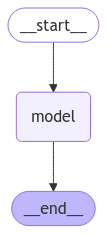

In [31]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Configure the graph

In [36]:
from langchain_openai import ChatOpenAI
from typing import Optional
from langchain_core.runnables.config import RunnableConfig

openai_model = ChatOpenAI(model="gpt-4o-mini")

models = {
    "anthropic": model,
    "openai": openai_model,
}


def _call_model(state: AgentState, config: RunnableConfig):
    # Access the config through the configurable key
    model_name = config["configurable"].get("model", "anthropic")
    model = models[model_name]
    response = model.invoke(state["messages"])
    return {"messages": [response]}


# Define a new graph
builder = StateGraph(AgentState)
builder.add_node("model", _call_model)
builder.add_edge(START, "model")
builder.add_edge("model", END)

graph = builder.compile()

In [37]:
graph.invoke({"messages": [HumanMessage(content="hi")]})

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={'id': 'msg_01Kc2orZ7gtAgjouRKYmYEeS', 'model': 'claude-2.1', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 6}}, id='run-2b8c226d-e133-4f64-8008-80c02c5960c9-0', usage_metadata={'input_tokens': 10, 'output_tokens': 6, 'total_tokens': 16, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}

In [38]:
config = {"configurable": {"model": "openai"}}
graph.invoke({"messages": [HumanMessage(content="hi")]}, config=config)

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-7339204e-bdfd-4240-8941-9bc9371f224c-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

system message

In [39]:
from langchain_core.messages import SystemMessage


# We can define a config schema to specify the configuration options for the graph
# A config schema is useful for indicating which fields are available in the configurable dict inside the config
class ConfigSchema(TypedDict):
    model: Optional[str]
    system_message: Optional[str]


def _call_model(state: AgentState, config: RunnableConfig):
    # Access the config through the configurable key
    model_name = config["configurable"].get("model", "anthropic")
    model = models[model_name]
    messages = state["messages"]
    if "system_message" in config["configurable"]:
        messages = [
            SystemMessage(content=config["configurable"]["system_message"])
        ] + messages
    response = model.invoke(messages)
    return {"messages": [response]}


# Define a new graph - note that we pass in the configuration schema here, but it is not necessary
workflow = StateGraph(AgentState, ConfigSchema)
workflow.add_node("model", _call_model)
workflow.add_edge(START, "model")
workflow.add_edge("model", END)

graph = workflow.compile()

In [40]:
graph.invoke({"messages": [HumanMessage(content="hi")]})

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Hello!', additional_kwargs={}, response_metadata={'id': 'msg_018wATEwaPNagiAeaAUDHVKF', 'model': 'claude-2.1', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 10, 'output_tokens': 6}}, id='run-72ee9dc6-f0ad-40c1-8729-8e57bb417079-0', usage_metadata={'input_tokens': 10, 'output_tokens': 6, 'total_tokens': 16, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}

In [41]:
config = {"configurable": {"system_message": "respond in italian"}}
graph.invoke({"messages": [HumanMessage(content="hi")]}, config=config)

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Ciao!', additional_kwargs={}, response_metadata={'id': 'msg_01Gj14y3AyPZ5YcjDxAJUvaM', 'model': 'claude-2.1', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 14, 'output_tokens': 7}}, id='run-202e2f51-2fa1-4243-9a41-1fdb34f66d5b-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}